In [5]:
from pytrends.request import TrendReq
from matplotlib import pyplot as plt

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Vizu settings
%matplotlib inline
plt.rcParams['font.size'] = 16
plt.rcParams['figure.figsize'] = (10, 6)

# Local imports
from utils import load_countries, plot_history
from search_engine import SearchEngine

# reproducibility
import random
random.seed(1337)

In [6]:
COUNTRY_DIR = "countries.txt"
COUNTRY_IGNORE_DIR = "ignore.txt"
LANGUAGE = 'en-US'
TIME_ZONE = 360

search_engine = SearchEngine(
    pytrends = TrendReq(hl=LANGUAGE, tz=TIME_ZONE),
    supported_countries = load_countries(filename=COUNTRY_DIR, ignore=COUNTRY_IGNORE_DIR),
    fetch_interval = 1
)

### Alterantive query: 1

```python
YEAR = 2019
FETCH_INTERVAL = 1
SEARCH_TERMS = ["ski"]
SEARCH_COUNTRIES = ["Norway", "Sweden", "Denmark"]
```

### Alterantive query: 1

```python
YEAR = 2019
FETCH_INTERVAL = 1
SEARCH_TERMS = ["ski"]
SEARCH_COUNTRIES = 3 
# 0: int .. returns all available countries
# 3: int .. returns 3 random countries 
# X: int .. returns X random countries 
```

### Alterantive query: 1

```python
YEAR = 2019
FETCH_INTERVAL = 1
SEARCH_TERMS = ["cheese", "wine"]
SEARCH_COUNTRIES = ["Italy", "France", "Spain"]
```

In [7]:
YEAR = 2018
SEARCH_TERMS = ["cheese", "wine"]
SEARCH_COUNTRIES = ["Italy", "France", "Spain"]

### Query the Google API via our Search Engine

In [8]:
history = search_engine.get_daily_trends_by_year(
    search_terms=SEARCH_TERMS,
    year=YEAR,
    countries=SEARCH_COUNTRIES
)

Fetching trends: 100%|██████████| 3/3 [00:09<00:00,  3.07s/it]


#### Display trends

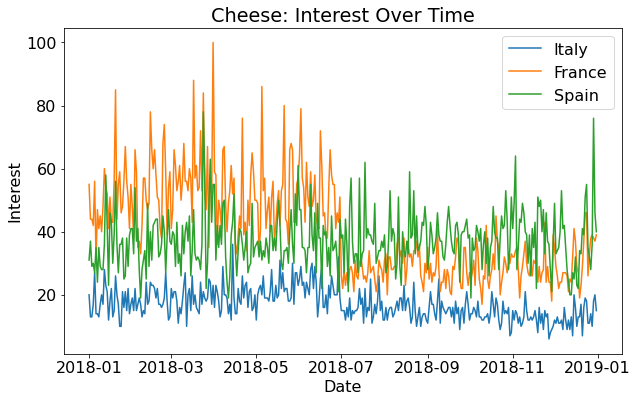

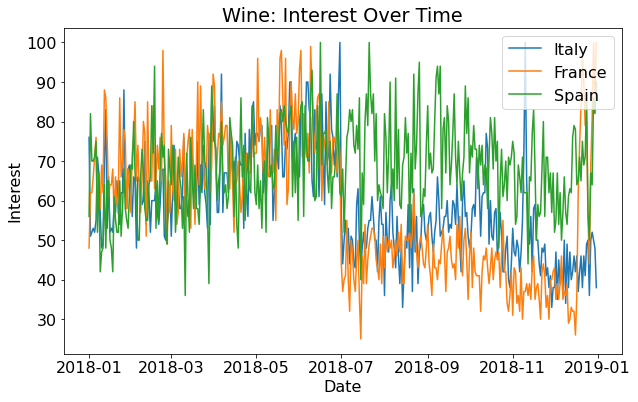

In [9]:
plot_history(history, SEARCH_TERMS)